# US Federal Public Debt, Annual Tax Revenue, Budget Deficit, and Interest Payments on Public Debt
This notebook looks at the evolution of US Federal Public Debt as percentage of GDP, Public Debt as percentage of Federal annual tax revenue, as well as annual public deficit as percentafe of GDP. Wherever possible I make use of data series with quarterly frequencies provided by [FRED](https://fred.stlouisfed.org). In case of tax revenue and budget deficit, I convert these quartely amounts into yearly amounts using the trailing 4 quarters approach. This way I get a new annual tax revenue (or budget deficit) for every quarter comprising the most recent 4 quarters.

In all time series and graphs, the reading for the start of the quarter designates the amount for the end of the quarter. I.e. total federal debt of $30400960 mln for 2022-01-01 designates the amount for the end of the quarter that starte on 2022-01-01.

It's not sufficient to just look at the size of the public debt. Prodigious as it may appear, to comprehend how burdonsome it is we need to look at:
* The costs of servicing it to the Federal Tax revenues. Despite the growing debt, the ratio of interest outlays to tax revenues is below the levels of the 80s and below the average calculated since 1969. It has never exceeded 8% of tax revenues so far.
* The cause of increases in the debt &mdash; public deficit &mdash; and what percentage of the GDP it takes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

In [3]:
# Human readable column names for DataFrames
FEDERAL_DEBT = 'Federal Debt'
FEDERAL_DEBT_TO_GDP = 'Federal Debt as Percent of GDP'
FEDERAL_TAX_REVENUE = 'Federal Annual Tax Revenue'
FEDERAL_DEBT_TO_TAX = 'Federal Debt as Percent of Annual Tax Revenue'
FEDERAL_BUDGET_DEFICIT = 'Federal Budget Deficit'
FEDERAL_DEFICIT_TO_GDP = 'Federal Deficit as Percent of GDP'
FEDERAL_DEBT_INTEREST = 'Federal Debt Annual Interest Outlays'
FEDERAL_DEBT_INTEREST_TO_TAX = 'Federal Debt Interest Outlays as Percent of Tax Revenue'
GS10 = '10y Treasury Yield'

### Federal Debt and Tax Receipts
There are five relevant dataseries provided by [FRED](https://fred.stlouisfed.org) that could potentially be used:
* `GFDEBTN` &mdash; Federal Debt: Total Public Debt in millions (quarterly frequency). This series accounts for both federal debt held by the public as well as US intragovernmental debt.
* `W006RC1Q027SBEA` &mdash; Federal government current tax receipts in billions (quarterly frequency). This series returns quarterly tax revenues. Since ratios involving national debt conventionally use annual amounts, I resample it to return annual tax revenues using the sum of the trailing 4 quarters.
* `GFDEGDQ188S` &mdash; Federal Debt: Total Public Debt as Percent of Gross Domestic Product (quarterly frequency). Like `GFDEBTN` this series accounts for both federal debt held by the public as well as intragovernmental debt.
* `FYGFDPUN` &mdash; unlike `GFDEBTN` this series accounts only for federal debt held by the public in millions (quarterly frequency).
* `FYGFGDQ188S` &mdash; unlike `GFDEGDQ188S` this series accounts only for federal debt held by the public as percent of GDP (quarterly frequency).

In this notebook I look at the total federal debt `GFDEBTN` rather than `FYGFDPUN` (i.e. inclusive of the part the government owns to itself). If you want to exclude it, please replace `GFDEBTN` with `FYGFDPUN` and `GFDEGDQ188S` with `FYGFGDQ188S`.

In [4]:
# GFDEBTN         -- Federal Debt: Total Public Debt in millions (quarterly frequency)
# W006RC1Q027SBEA -- Federal government current tax receipts in billions (quarterly frequency)
# GFDEGDQ188S     -- Federal Debt: Total Public Debt as Percent of Gross Domestic Product (quarterly frequency)
fred_pub_debt_and_tax_rev = web.get_data_fred(['GFDEBTN', 'W006RC1Q027SBEA', 'GFDEGDQ188S'],
                                              start=report_start, end=report_end)

# Converting current tax receipts to millions
fred_pub_debt_and_tax_rev.W006RC1Q027SBEA *= 1000 

# Converting current tax recepits from quarterly to annual (trailing 4 quarters)
fred_pub_debt_and_tax_rev.W006RC1Q027SBEA = fred_pub_debt_and_tax_rev.W006RC1Q027SBEA.rolling(4).sum()

# Adding as a new column in the main DataFrame for Federal Debt to Annual Tax Revenue Ratio
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX] = fred_pub_debt_and_tax_rev.GFDEBTN / fred_pub_debt_and_tax_rev.W006RC1Q027SBEA * 100

###  Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity

In [5]:
# GS10 -- Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis
#         (monthly frequency)
treasury_yield_10y = web.get_data_fred('GS10', start=report_start, end=report_end)

# Downsample to quarterly frequency, taking the mean over a given quarter and rounding to two decimal points
treasury_yield_10y = treasury_yield_10y.GS10.resample('QS').mean().round(2)

# Adding as a new column in the main DataFrame for 10y treasury yield
fred_pub_debt_and_tax_rev[GS10] = treasury_yield_10y

###  Interest Payments on Federal Public Debt
The only useful dataseries provided by [FRED](https://fred.stlouisfed.org) is:
* `FYOINT` &mdash; Federal Outlays: Interest in millions (annual frequency). Unfortunately it's only avialable
with annual frequencies. So I need to upsample it into quarterly frequencies and deal with the change in
fiscal year ends starting from 1977 (from end of June in prior years to end of September from 1977 onwards).

In [6]:
# FYOINT -- Federal Outlays: Interest in millions (annual frequency)
interest_payments = web.get_data_fred('FYOINT', start=report_start, end=report_end)

# In years up to 1976 fiscal year end was end of June, in the years thereafter
# end of September. This needs to be properly accounted for when upsampling into quarter frequency.
interest_payments_A_JUN = interest_payments[:'1976'].asfreq('A-JUN')
interest_payments_A_SEP = interest_payments['1977':].asfreq('A-SEP')

interest_payments_QS = interest_payments_A_JUN.resample('QS').bfill(limit=4).FYOINT
interest_payments_QS_from_1977 = interest_payments_A_SEP.resample('QS').bfill(limit=4).FYOINT

# Add 4 missing quarters with missing quarters for backfilling
missing_quarters = pd.Series(np.nan, index=pd.date_range("1976-07-01", periods=4, freq="QS"))
interest_payments_QS_from_1977 = pd.concat([missing_quarters, interest_payments_QS_from_1977]).bfill(limit=4)
interest_payments_QS = pd.concat([interest_payments_QS, interest_payments_QS_from_1977])

# Adding as a new column in the main DataFrame for interest payments on public debt
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST] = interest_payments_QS
# Adding as a new column in the main DataFrame for nterest payments on public debt to Annual Tax Revenue Ratio
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST_TO_TAX] = interest_payments_QS / fred_pub_debt_and_tax_rev.W006RC1Q027SBEA * 100

# Best guess for the last year
fred_pub_debt_and_tax_rev.ffill(limit=3, inplace=True)

### Federal Budget Deficit and Budget Deficit to GDP
There are a few relevant dataseries provided by [FRED](https://fred.stlouisfed.org) that could potentially be used:
* `M318501Q027NBEA` &mdash; Federal government budget surplus in billions (quarterly frequency, from 1957). Unfortunately it is not frequently updated and lacks the last quarters
* `MTSDS133FMS` &mdash; Federal Surplus or Deficit in millions (monthly frequency, from 1980). This one contains the most recent months.
* `GDP` &mdash; Gross Domestic Product in in billions (quarterly frequency, from 1930)

In this notebook I use `M318501Q027NBEA` as the basis. I extend it with the most recent quarters by appropriately resampling `MTSDS133FMS`. Since federal budget has predominantly featured deficit lately, I convert surpluses into deficits &mdash; i.e. a positive amount designates a deficit, while a negative denotes a surplus. Given that ratios involving national debt conventionally use annual amounts, I resample it to return annual budget deficits using the sum of the trailing 4 quarters. This way I get a new annual budget deficit for every quarter comprising the most recent 4 quarters.

The `GDP` series lets me calculate annual nudget deficit to GDP ratio with a frequency of every quarter.

In [7]:
# M318501Q027NBEA -- Federal government budget surplus in billions (quarterly frequency, from 1957)
# MTSDS133FMS     -- Federal Surplus or Deficit in millions (monthly frequency, from 1980)
# GDP             -- Gross Domestic Product in in billions (quarterly frequency, from 1930)

# Actually, MTSDS133FMS tracks surpluses, but I'll convert it to deficits
fed_budget_deficit_monthly = web.get_data_fred('MTSDS133FMS', start=report_start, end=report_end)
fed_budget_deficit_quarterly = web.get_data_fred('M318501Q027NBEA', start=report_start, end=report_end)
gdp = web.get_data_fred('GDP', start=report_start, end=report_end)

# Convert from DataFrames to Series, converting budget surpluses to deficits,
# and adjusting units from billions to millions where appropriate
fed_budget_deficit_monthly = fed_budget_deficit_monthly.MTSDS133FMS * -1
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.M318501Q027NBEA * -1000
gdp = gdp.GDP * 1000

# Making frequencies explicit
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.asfreq('QS')
fed_budget_deficit_monthly = fed_budget_deficit_monthly.asfreq('MS')
gdp = gdp.asfreq('QS')

# Aligning frequencies
fed_budget_deficit_quarterly_from_fy_1981Q1 = fed_budget_deficit_monthly.resample('QS').sum()

# Extending M318501Q027NBEA with new quarterly data
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.combine_first(fed_budget_deficit_quarterly_from_fy_1981Q1)

# Converting quarterly budget deficit into annual (trailing 4 quarters)
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.rolling(4).sum()

# Adding as a new column in the main DataFrame for budget deficits
fred_pub_debt_and_tax_rev[FEDERAL_BUDGET_DEFICIT] = fed_budget_deficit_quarterly

# Adding as a new column in the main DataFrame for deficit to gdp
fred_pub_debt_and_tax_rev[FEDERAL_DEFICIT_TO_GDP] = (fed_budget_deficit_quarterly / gdp * 100).fillna(method="ffill")

# Truncating to start of calendar year 1970
fred_pub_debt_and_tax_rev = fred_pub_debt_and_tax_rev.loc['1970':]

### Visualization of prepared data

In [8]:
fred_pub_debt_and_tax_rev.rename(
    columns={'GFDEBTN': FEDERAL_DEBT, 'W006RC1Q027SBEA': FEDERAL_TAX_REVENUE,
             'GFDEGDQ188S': FEDERAL_DEBT_TO_GDP, 'M318501Q027NBEA': FEDERAL_BUDGET_DEFICIT},
    inplace=True)

In [9]:
fred_pub_debt_and_tax_rev

,Federal Debt,Federal Annual Tax Revenue,Federal Debt as Percent of GDP,Federal Debt as Percent of Annual Tax Revenue,10y Treasury Yield,Federal Debt Annual Interest Outlays,Federal Debt Interest Outlays as Percent of Tax Revenue,Federal Budget Deficit,Federal Deficit as Percent of GDP
DATE,,,,,,,,,
1970-01-01,372007.0,564532.0,35.38879,65.896530,7.37,14380.0,2.547243,-3.967000e+03,-0.377378
1970-04-01,370094.0,556340.0,34.67329,66.522990,7.71,14380.0,2.584750,2.845000e+03,0.266542
1970-07-01,378678.0,547488.0,34.86717,69.166447,7.46,14841.0,2.710744,8.143000e+03,0.749775
1970-10-01,389158.0,537720.0,35.74822,72.371866,6.85,14841.0,2.759987,1.138100e+04,1.045464
1971-01-01,391668.0,535220.0,34.50345,73.178880,6.02,14841.0,2.772878,1.611500e+04,1.419629
...,...,...,...,...,...,...,...,...,...
2021-01-01,28132570.0,8406102.0,127.65351,334.668435,1.32,352338.0,4.191455,4.091364e+06,18.564852
2021-04-01,28529436.0,8921044.0,125.45397,319.799297,1.59,352338.0,3.949515,2.625178e+06,11.543832
2021-07-01,28428919.0,9394235.0,122.52606,302.620905,1.32,352338.0,3.750577,2.770842e+06,11.942076


#### US Total Federal Public Debt, Annual Tax Revenue, and Annual Budget Deficit from 1970
Throughout the rest of this notebook budget deficits are displayed as positive numbers, while surpluses as negative ones. Annual interest outlays are remarkably small due to the Fed keeping treasury rates down.

In [10]:
TOTAL_DEBT_GRAPH_TITLE = 'US Total Federal Public Debt, Annual Tax Revenue, Annual Budget Deficit, and Annual Interest Outlays'
LEFT_Y_AXIS_LABEL = 'Billions of USD'

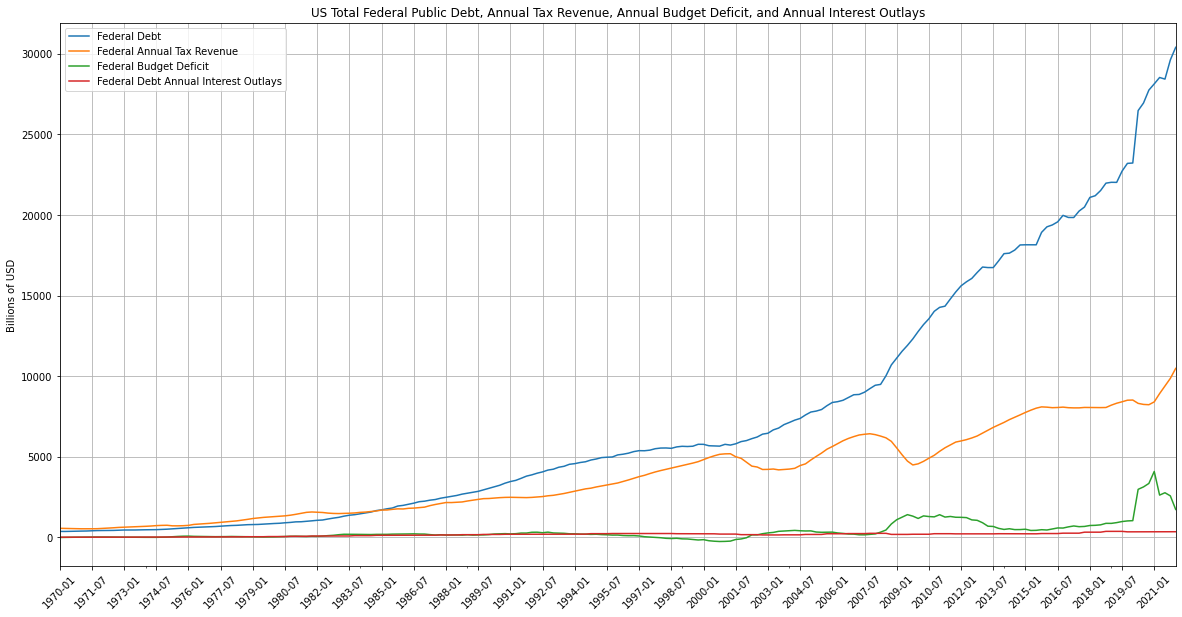

In [11]:
ax = fred_pub_debt_and_tax_rev[[FEDERAL_DEBT, FEDERAL_TAX_REVENUE, FEDERAL_BUDGET_DEFICIT, FEDERAL_DEBT_INTEREST]]\
            .plot(figsize=(20,10), grid=True, title=TOTAL_DEBT_GRAPH_TITLE, ylabel='Billions of USD',
                  xticks=fred_pub_debt_and_tax_rev.index[::6], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "%.0f" % (x/1000)))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), fred_pub_debt_and_tax_rev.index[::6])))

#### US Total Federal Public Debt, Annual Tax Revenue, and Annual Budget Deficit from 1990

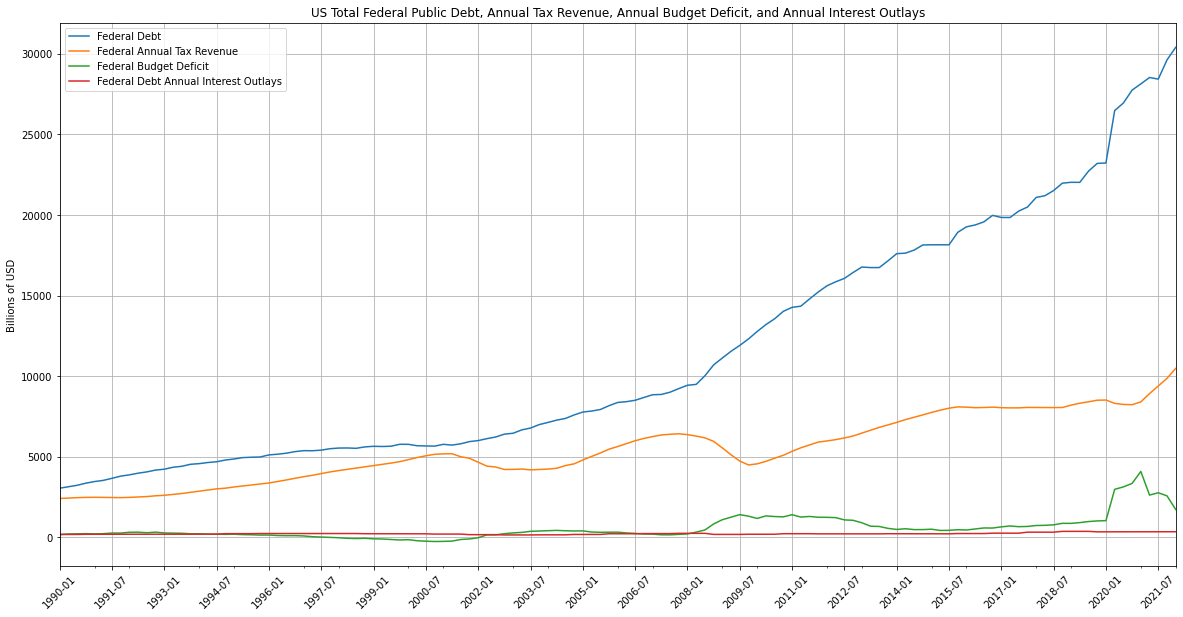

In [12]:
shorter_series = fred_pub_debt_and_tax_rev[[FEDERAL_DEBT, FEDERAL_TAX_REVENUE, FEDERAL_BUDGET_DEFICIT, FEDERAL_DEBT_INTEREST]]['1990':]
ax = shorter_series.plot(figsize=(20,10), grid=True,
                     title=TOTAL_DEBT_GRAPH_TITLE, ylabel=LEFT_Y_AXIS_LABEL,
                     xticks=shorter_series.index[::6], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "%.0f" % (x/1000)))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), shorter_series.index[::6])))

#### 10 Year Treasury Yield, US Total Federal Public Debt to GDP, Federal Debt to Annual Tax Revenue,  Annual Federal Deficit to GDP, and Annual Interest Outlays to Annual Tax Revenue ratios
Despite the growing debt, the ratio of interest outlays to tax revenues is below the levels of the 80s.

In [13]:
DEBT_RATIOS_GRAPH_TITLE = '10 Year Treasury Yield, US Total Federal Public Debt to GDP, Debt to Annual Tax Revenue, and Annual Federal Deficit to GDP ratios'
LEFT_Y_AXIS_LABEL = 'Federal Debt to GDP, Federal Debt to Annual Tax Revenue'
RIGHT_Y_AXIS_LABEL = '10 Year Treasury Yield, Annual Federal Deficit to GDP, Annual Interest Outlay to Tax Revenue'
DEBT_RATIOS_GRAPH_TITLE_SHORT = '10 Year Treasury Yield, Annual Federal Deficit to GDP, and Federal Debt Interest Outlays to Tax Revenue ratios'
LABEL_INTEREST_OUTLAYS_TO_TAX_REVS = 'Mean level of Federal Debt Interest Outlays to Tax Revenue'

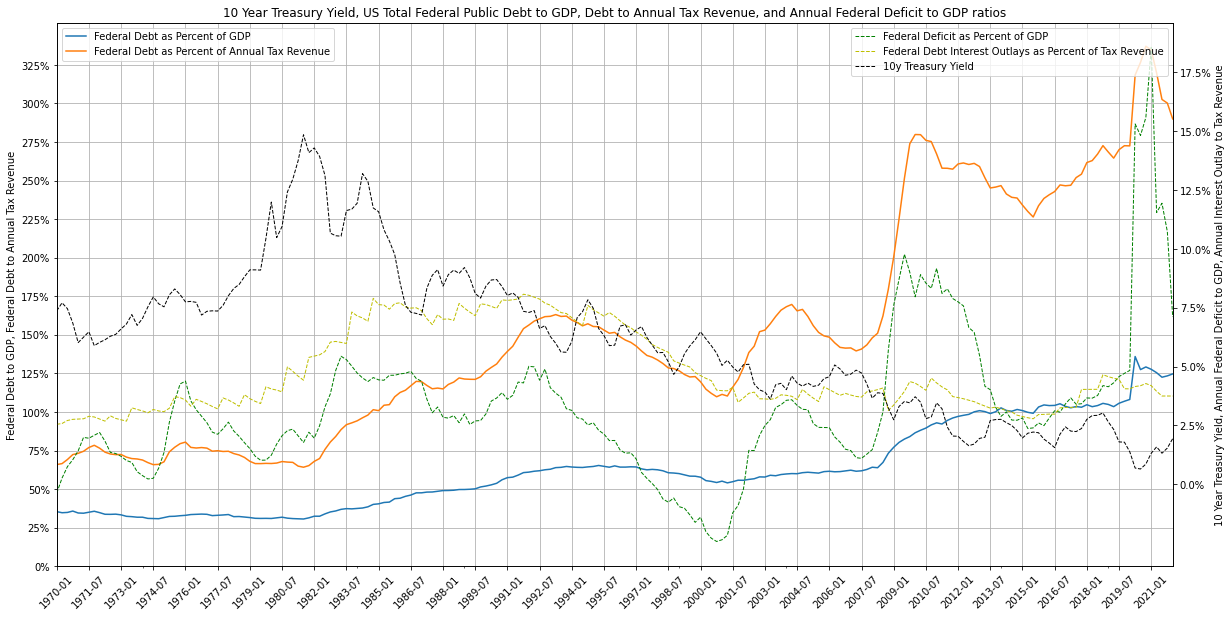

In [14]:
ax = fred_pub_debt_and_tax_rev[[FEDERAL_DEBT_TO_GDP, FEDERAL_DEBT_TO_TAX]].plot(figsize=(20,10), grid=True,
                     title=DEBT_RATIOS_GRAPH_TITLE,
                     xticks=fred_pub_debt_and_tax_rev.index[::6], xlabel='', rot=45, yticks=np.arange(0, 350, 25))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = fred_pub_debt_and_tax_rev[[FEDERAL_DEFICIT_TO_GDP, FEDERAL_DEBT_INTEREST_TO_TAX, GS10]].plot(ax=ax2, linewidth=1, linestyle='--',
    xticks=fred_pub_debt_and_tax_rev.index[::6], color=['g', 'y', 'k'], yticks=np.arange(0, 20, 2.5))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), fred_pub_debt_and_tax_rev.index[::6])))
ax2.legend(loc='upper right')
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
_ = ax2.set_ylabel(RIGHT_Y_AXIS_LABEL)

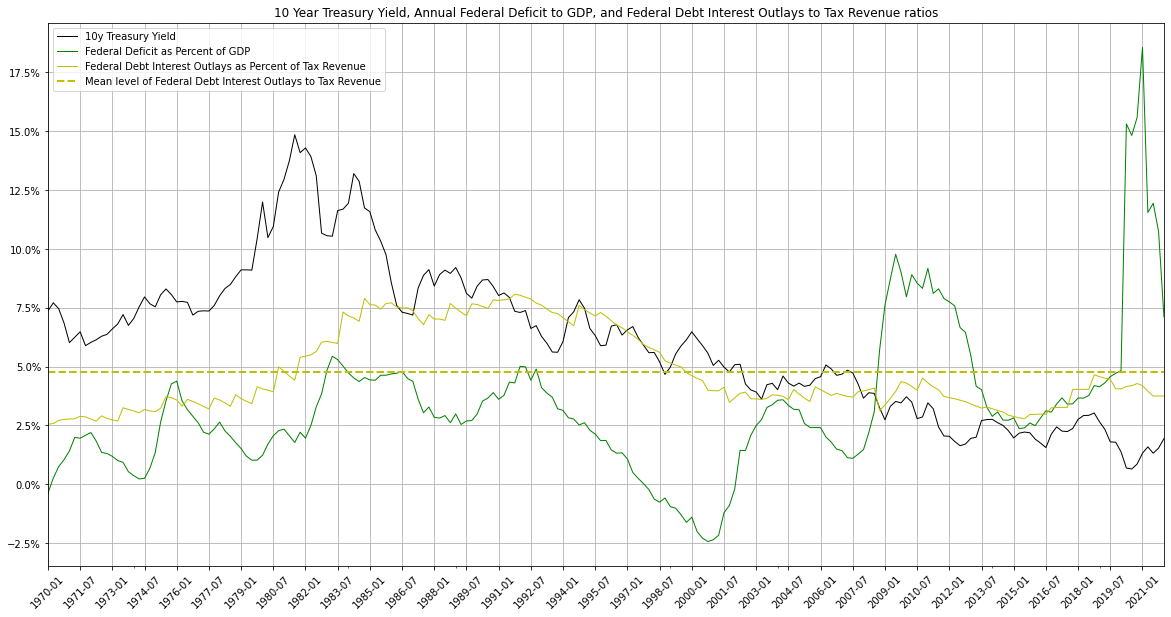

In [15]:
ax = fred_pub_debt_and_tax_rev[[GS10, FEDERAL_DEFICIT_TO_GDP, FEDERAL_DEBT_INTEREST_TO_TAX]].plot(
    figsize=(20,10), grid=True, linewidth=1, title=DEBT_RATIOS_GRAPH_TITLE_SHORT,
    xticks=fred_pub_debt_and_tax_rev.index[::6], color=['k', 'g', 'y'],
    xlabel='', rot=45, yticks=np.arange(-2.5, 20, 2.5))
ax.axhline(y=fred_pub_debt_and_tax_rev.loc[:, FEDERAL_DEBT_INTEREST_TO_TAX].mean(), lw=2, c='y', ls='--',
           label=LABEL_INTEREST_OUTLAYS_TO_TAX_REVS)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), fred_pub_debt_and_tax_rev.index[::6])))

#### 10 Year Treasury Yield, US Total Federal Public Debt to GDP, Federal Debt to Annual Tax Revenue,  Annual Federal Deficit to GDP, and Annual Interest Outlays to Annual Tax Revenue ratios from 1990 and onwards

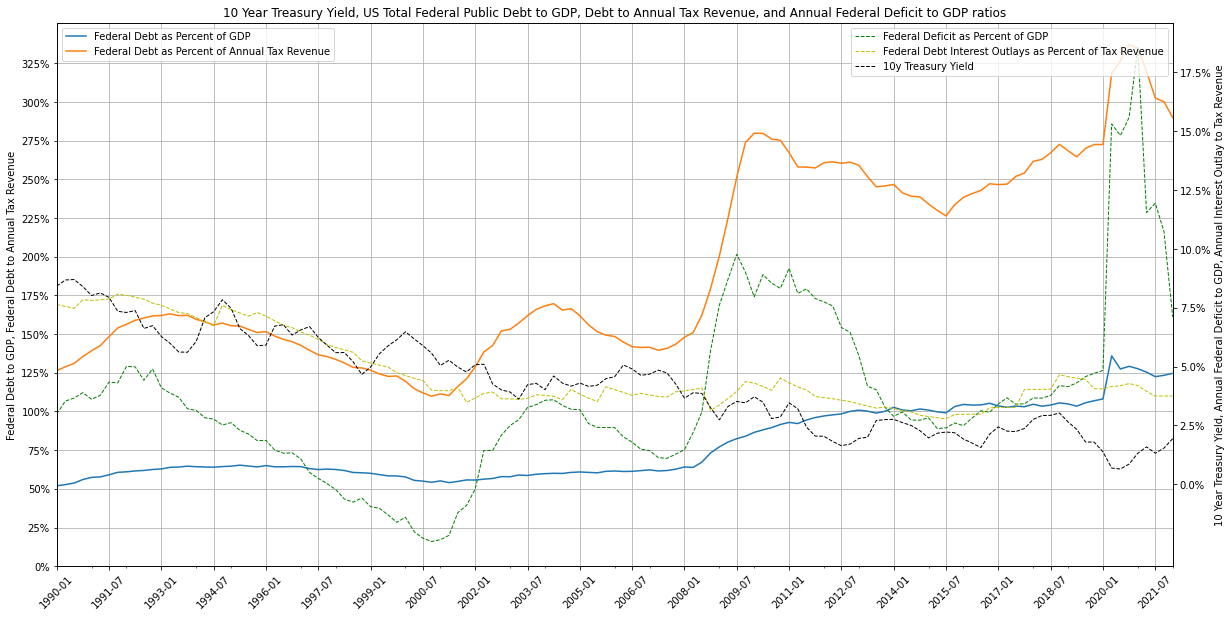

In [16]:
shorter_series = fred_pub_debt_and_tax_rev[[FEDERAL_DEBT_TO_GDP, FEDERAL_DEBT_TO_TAX]]['1990':]
shorter_series2 = fred_pub_debt_and_tax_rev[[FEDERAL_DEFICIT_TO_GDP, FEDERAL_DEBT_INTEREST_TO_TAX, GS10]]['1990':]
ax = shorter_series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE,
                     xticks=shorter_series.index[::6], xlabel='', rot=45, yticks=np.arange(0, 350, 25))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = shorter_series2.plot(ax=ax2, linewidth=1, linestyle='--', color=['g', 'y', 'k'],
    xticks=shorter_series2.index[::6], yticks=np.arange(0, 20, 2.5))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), shorter_series2.index[::6])))
ax2.legend(loc='upper right')
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
_ = ax2.set_ylabel(RIGHT_Y_AXIS_LABEL)